In [1]:
# All Required Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
from PIL import Image

### Defined Functions

In [2]:
# Function to get the online images
def load_image(name, no_alpha=True):
    url = f'https://cloud.dfki.de/owncloud/index.php/s/THLirfoB6SYTetn/download?path=&files={name}'
    image = np.asarray(Image.open(requests.get(url, stream=True).raw))
    if no_alpha and len(image) > 2 and image.shape[2] == 4:
        image = image[:,:,:3]
    return image[:,:,::-1].copy()

# Function to resize the image
def resize(image, scale):
    return cv2.resize(image, (int(image.shape[1]*scale), int(image.shape[0]*scale)))

# Function to print the image 
def show(*images, titles=None, figsize=None, **kwargs):
    ROWS, COLS = 1, len(images)
    if figsize is not None:
        plt.figure(figsize=(18,6))
    for i, img in enumerate(images):
        plt.subplot(ROWS, COLS, i+1)
        if titles is not None:
            plt.title(titles[i])
        if len(img.shape) == 3:
            plt.imshow(img[:,:,::-1], **kwargs)
        else:
            plt.imshow(img, **kwargs)
    plt.show()

# Function to convert RGB image into Gray Scale
def gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Function to filter the image
def conv(image, kernel):
    return cv2.filter2D(src=image, ddepth=-1, kernel=kernel)

# Function to apply Gaussian Blur
def gaussian_blur(image, size):
    return cv2.GaussianBlur(image, (size, size), 0)

<p style="page-break-after:always;"></p>

# Task: Edge Detection
---

Edge detection is the task of detecting areas of sudden intensity change in the image.

<div style="background-color: #ffa252; color: #ffffff; width: 100%; padding: 0.3em; font-size:1.1em; font-weight: bold;">Canny Edge Detector</div>
<div style="background-color: #ffecdc; width: 100%; padding-top: 0.5em; padding-bottom: 0.3em">
    
1. Noise reduction
2. Gradient calculation (using Sobel)
3. Non-maximum suppression
4. Hysteresis thresholding
5. Edge Tracking by Hysteresis.

</div>


**TASK:**
* Load the image `img1.png`.
* Convert it to grayscale
* Blur it with a gaussian filter of size 9. (I have choosen size 9, you can choose any other size as you wish.)

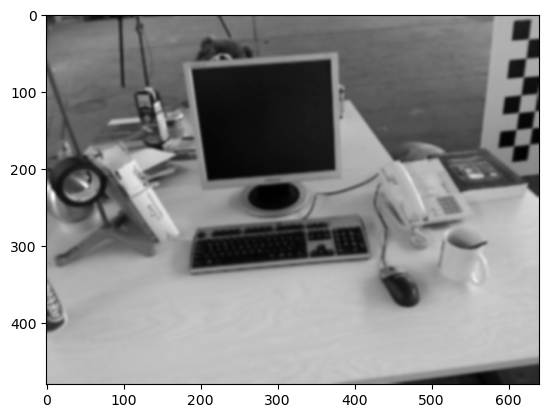

In [3]:
I = gray(load_image("img1.png"))

# Applying Gaussian blur to the input image 
I=gaussian_blur(I,9)
I_blured = I  

show(I_blured, cmap="gray")

**TASK:**
Function that computes the image gradients by:
1. Apply sobel filter in X and Y direction to the image.
    - Define the filter kernels as global constants SOBEL_X and SOBEL_Y. We will need them again in a later task.
2. Compute the magnitude of the gradient
    - The length of the magnitude vector (sobel in x and sobel in y)
    - Note: the `np.hypot(x1,x2)` function computes $\sqrt{x_1^2+x_2^2}$
3. Compute the orientation of the gradient
    - Note: `np.arctan2(y,x)` computes $tan^{-1}(\frac{y}{x})$.
4. Return magnitude and orientation

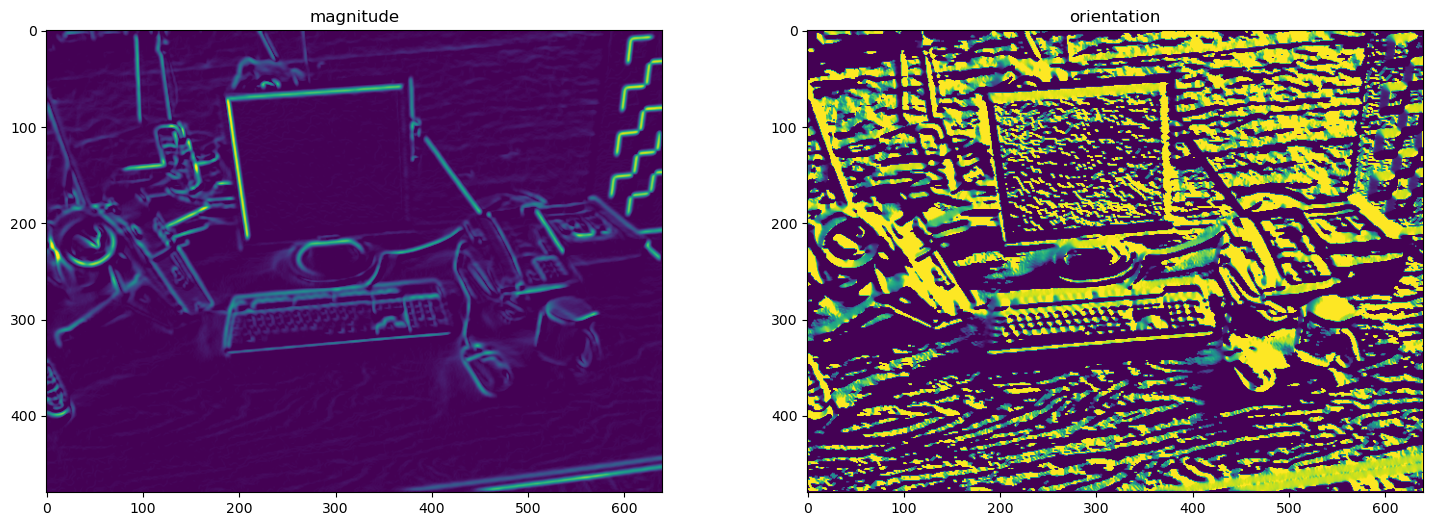

In [4]:
# Sobel Filter in X & Y Directions
SOBEL_X = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=np.float32)              
SOBEL_Y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32)

def compute_grads(I):
    # Applying convolution on gaussian blured image in x and y direction using respective sobel filters
    output_image_x=conv(I,SOBEL_X)      
    output_image_y=conv(I,SOBEL_Y)
    
    #Calculating the magnitude by applying the above formula and using the function np.hypot
    magnitude = np.hypot(output_image_x,output_image_y)  

    # Calculating the orientation by applying the above formula and using the function arctan2
    orientation = np.arctan2(output_image_y,output_image_x)  
    
    return magnitude, orientation

magnitude, orientation = compute_grads(I_blured)
show(
    magnitude, orientation,
    titles=["magnitude", "orientation"],
    figsize=(16,4)
)

**TASK:**
Function that computes the non maximum suppresion considering the direction of the gradients.
* For each pixel compare the value to next to it in the direction of the magnitude.
* The pixels can be found based on the orientation according to the semi circular diagram.
* Only keep the pixel values where the neighbours are smaller than self.

![image-2.png](image-2.png)
**Fig:** Visualization on how pixels and angles match. Note, that above 180° the result is point symmetric (thus not drawn).

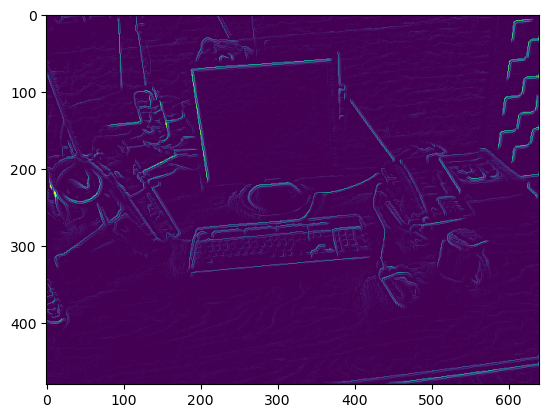

In [5]:
def non_max_suppression(magnitude, orientation):

    orientation=orientation*180/np.pi                                # Converting the orientation map from radians to degrees

    # Computing Non Maximum Suppression over both the images
    for i in range (magnitude.shape[0]-1):
        for j in range (magnitude.shape[1]-1):

            # Using the above images as reference and classifying according to the orientation. 
            # If these values do not coincide then assigning them as 0 or else neglecting them.
            if orientation[i,j]<22.5 or orientation[i,j]>157.5:             
                if magnitude[i,j]<magnitude[i,j+1] or magnitude[i,j]<magnitude[i,j-1]:
                    magnitude[i,j]=0

            elif 22.5<orientation[i,j]<67.5:
                if magnitude[i,j]<magnitude[i+1,j+1] or magnitude[i,j]<magnitude[i-1,j-1]:
                    magnitude[i,j]=0
            
            elif 67.5<orientation[i,j]<112.5:
                if magnitude[i,j]<magnitude[i+1,j] or magnitude[i,j]<magnitude[i-1,j]:
                    magnitude[i,j]=0
            
            elif 112.5<orientation[i,j]<157.5:
                if magnitude[i,j]<magnitude[i+1,j-1] or magnitude[i,j]<magnitude[i-1,j+1]:
                    magnitude[i,j]=0
    
    return magnitude

magnitude_nms = non_max_suppression(magnitude, orientation)
show(magnitude_nms)

**TASK:**
Double threshold, i.e., remove non relevant pixels
* For each pixel set it to `strong` if above high threshold, to `weak` if between high and low threshold and to `0` if less than low threshold.
* The high threshold is computed as a $T_h = \alpha I_{max}$ and the low threshold is $T_l = \beta T_h$
* Use the default values $\beta = 0.05$, $\alpha=0.09$.


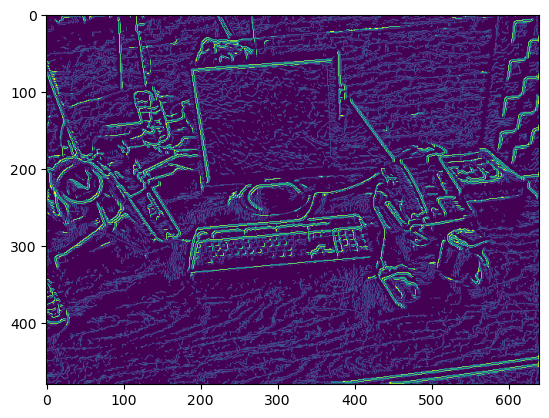

In [6]:
WEAK = 64
STRONG = 255

def double_threshold(magnitude, alpha=0.09, beta=0.05):

    magnitude_output=np.zeros_like(magnitude)                                           # Initialising the output matrix

    # Computing whether an edge is a strong or weak edge.
    # This can be done by checking the neighbouring values.
    for i in range (magnitude.shape[0]):
        for j in range (magnitude.shape[1]):
            
            #If the neighbouring values are greater than the value Th=alpha*Imax then assign STRONG.
            if magnitude[i,j]>alpha*np.max(magnitude):
                magnitude_output[i,j]=STRONG

            # If the neighbouring values are in between Th and Tl=beta*Th then assign WEAK.
            elif beta*alpha*np.max(magnitude)<magnitude[i,j]<alpha*np.max(magnitude):
                magnitude_output[i,j]=WEAK

    return magnitude_output

magnitude_threshold = double_threshold(magnitude_nms)
show(magnitude_threshold)

**TASK:**
Edge tracking by hysteresis - Track the pixel intensity, link strong edge pixel and weak pixel
1. For each weak pixel in the image
    - make it a strong pixel if any of the 8 neighbours is a strong pixel
2. Repeat step 1 until no more pixels are made strong in a pass
3. Finally make all remaining weak pixels `0`.

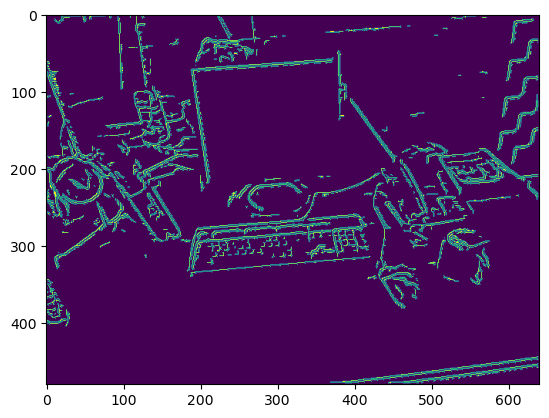

In [7]:
def hysteresis(magnitude_threshold):
    
    magnitude_output=np.zeros_like(magnitude_threshold)                         # Initialising the output matrix
    
    # If any of the neighbouring pixels are STRONG of a WEAK pixel then make them STRONG as well.
    for i in range(magnitude_threshold.shape[0]-1):
        for j in range (magnitude_threshold.shape[1]-1):
            if magnitude_threshold[i,j]==WEAK:
                if magnitude_threshold[i-1,j-1]==STRONG or magnitude_threshold[i-1,j]==STRONG or magnitude_threshold[i-1,j+1]==STRONG or magnitude_threshold[i,j-1]==STRONG or magnitude_threshold[i,j+1]==STRONG or magnitude_threshold[i+1,j-1]==STRONG or magnitude_threshold[i+1,j]==STRONG or magnitude_threshold[i+1,j+1]==STRONG:
                    magnitude_output[i,j]=STRONG
            else:
                magnitude_output[i,j]=magnitude_threshold[i,j]
                
    return magnitude_output

edges = hysteresis(magnitude_threshold)
show(edges)

**TASK:** Since we have defined all the functions required to perform the edge detection, we are now combining all the steps. 
1. Blur
2. Extract gradients
3. NMS
4. Double threshold
5. Conncet via hysteresis

Apply the function on `img1.png` and `park.png`.


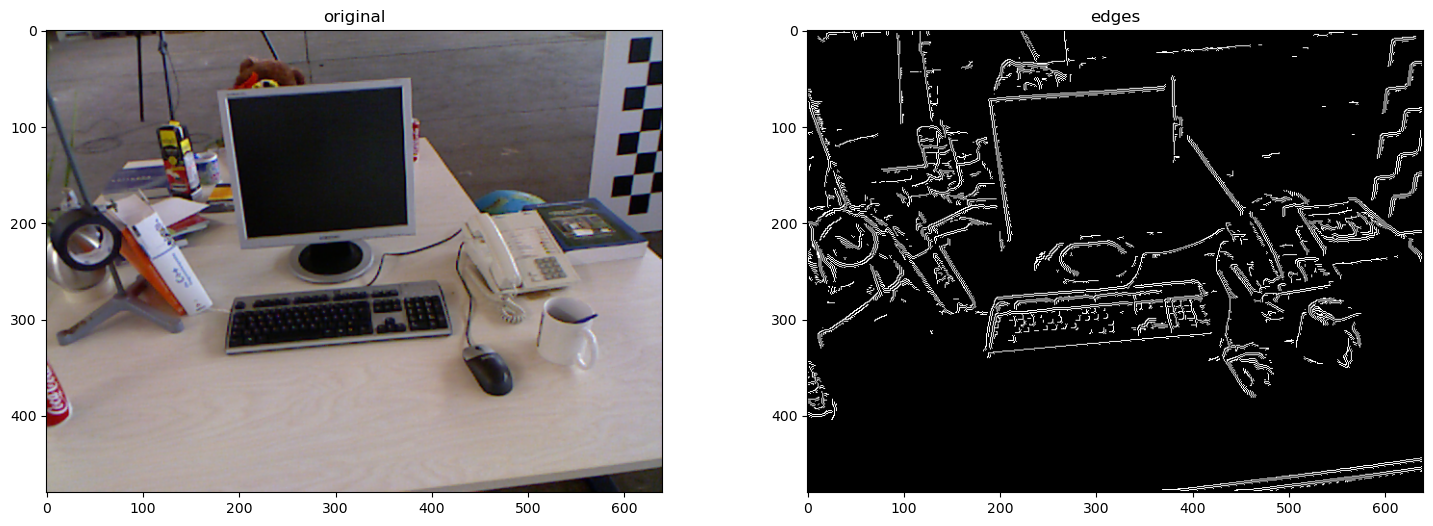

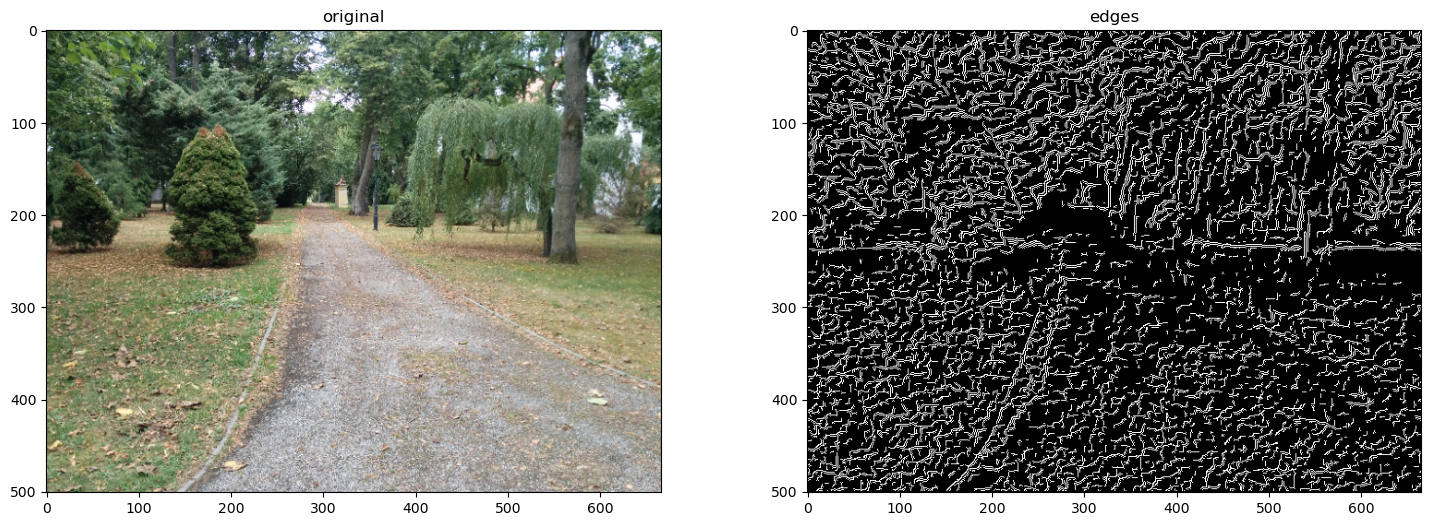

In [8]:
def canny_edge(I):
    # Compiling all the above defined functions
    magnitude,orientation=compute_grads(gaussian_blur(I,9))
    I=hysteresis(double_threshold(non_max_suppression(magnitude,orientation)))
    return I

I = load_image("img1.png")
show(
    I, canny_edge(gray(I)),
    titles=["original", "edges"],
    figsize=(16,4),
    cmap="gray"
)
I = load_image("park.png")
show(
    I, canny_edge(gray(I)),
    titles=["original", "edges"],
    figsize=(16,4),
    cmap="gray"
)